<a href="https://colab.research.google.com/github/rajveer43/gnn_july24/blob/master/gnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch

os.environ['TORCH'] = torch.__version__
os.environ['CUDA'] = torch.version.cuda
print(os.environ['TORCH'])

!pip install -q pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-geometric

from torch.nn import ReLU, Softmax
import torch.nn.functional as F
import torch_geometric
from torch_geometric.datasets import DBLP
import torch_geometric.transforms as T
from torch_geometric.nn import Sequential, Linear, GCNConv, SAGEConv, GATConv, GATv2Conv, to_hetero
from torch_geometric.utils import softmax

import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.reset_defaults()
sns.set_theme(rc={"figure.dpi": 72, "savefig.dpi": 300,
              "figure.autolayout": True})
sns.set_style("ticks")
sns.set_context("paper")

np.set_printoptions(precision=4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2.3.1+cu121
ERROR: Could not find a version that satisfies the requirement pyg-lib (from versions: none)
ERROR: No matching distribution found for pyg-lib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.6 MB/s eta 0:00:00


In [2]:
dataset = DBLP("q1", transform=T.Constant(node_types='conference'))
data = dataset[0]

Extracting q1/raw/DBLP_processed.zip
Processing...
Done!


In [3]:
num_classes = len(np.unique(data["author"].y))
print(dataset)
print("Number of graphs:", len(dataset))
print("Number of nodes:", data.num_nodes)
print("Number of edges:", data.num_edges)
print("Number of node features:", data.num_node_features)
print("Number of edge features:", data.num_edge_features)
print("Number of classes:", num_classes)
print("Average node degree:", round(data.num_edges / data.num_nodes, 2))
print("Number of training nodes:", data["author"].train_mask.sum().item())
print("Number of validation nodes:", data["author"].val_mask.sum().item())
print("Number of test nodes:", data["author"].test_mask.sum().item())
print("Is directed:", data.is_directed())
print("Has isolated nodes:", data.has_isolated_nodes())
print("Has self loops:", data.has_self_loops())
print()
print("Other information:")
print(data)
data = data.to(device)

DBLP()
Number of graphs: 1
Number of nodes: 26128
Number of edges: 239566
Number of node features: {'author': 334, 'paper': 4231, 'term': 50, 'conference': 1}
Number of edge features: {('author', 'to', 'paper'): 0, ('paper', 'to', 'author'): 0, ('paper', 'to', 'term'): 0, ('paper', 'to', 'conference'): 0, ('term', 'to', 'paper'): 0, ('conference', 'to', 'paper'): 0}
Number of classes: 4
Average node degree: 9.17
Number of training nodes: 400
Number of validation nodes: 400
Number of test nodes: 3257
Is directed: False
Has isolated nodes: False
Has self loops: False

Other information:
HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ e

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch_geometric.datasets import DBLP
from torch_geometric.data import HeteroData

# Load the DBLP dataset
dataset = DBLP(root='data/DBLP')
data = dataset[0]

# Convert to NetworkX graph
def to_networkx(data):
    G = nx.Graph()

    # Add nodes
    for node_type in data.node_types:
        for i in range(data[node_type].num_nodes):
            G.add_node(f"{node_type}_{i}", type=node_type)

    # Add edges
    for edge_type in data.edge_types:
        src, dst = data[edge_type].edge_index
        for s, d in zip(src, dst):
            G.add_edge(f"{edge_type[0]}_{s.item()}", f"{edge_type[2]}_{d.item()}")

    return G

G = to_networkx(data)

# Visualize the graph
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, seed=42)  # Layout for visualization
node_colors = [G.nodes[n]['type'] for n in G.nodes]
color_map = {'author': 'red', 'paper': 'blue', 'term': 'green', 'conference': 'yellow'}
node_colors = [color_map[n] for n in node_colors]

nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=50, edge_color='gray', alpha=0.5)
plt.title("DBLP Dataset Visualization")
plt.show()


Extracting data/DBLP/raw/DBLP_processed.zip
Processing...
Done!


KeyboardInterrupt: 

In [4]:
def train(model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data["author"].train_mask
    loss = F.cross_entropy(out["author"][mask], data["author"].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)

# Testing function
def test(model):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict)["author"].argmax(dim=-1)
    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data["author"][split]
        acc = (pred[mask] == data["author"].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs

# Function to plot epoch results
def epoch_plot(model, optimizer, max_epoch=100, save="epoch.png"):
    values = []
    for i in range(max_epoch):
        loss = train(model, optimizer)
        accs = test(model)
        values.append([i+1, loss, *accs])
    df = pd.DataFrame(values, columns=["Epoch", "Loss", "Train", "Validation", "Test"])
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(data=df, x="Epoch", y="Loss", ax=ax[0])
    sns.lineplot(data=df, x="Epoch", y="Train", label="Train", ax=ax[1])
    sns.lineplot(data=df, x="Epoch", y="Validation", label="Validation", ax=ax[1])
    sns.lineplot(data=df, x="Epoch", y="Test", label="Test", ax=ax[1])
    ax[1].set(ylabel="Accuracy")
    fig.savefig(save)
    plt.show()

In [5]:
def eval(model, optimizer, max_epoch=100):
    values = []
    t = time.time()
    for i in range(max_epoch):
        loss = train(model, optimizer)
        accs = test(model)
        values.append([i+1, loss, *accs])
    t = time.time() - t
    df = pd.DataFrame(values, columns=["Epoch", "Loss", "Train", "Validation", "Test"])
    acc = df.iloc[-1, -1]
    print(f"Accuracy: {acc:.4f}")
    print(f"Computation Time: {t:.4f}s")

In [6]:
def gcn(hidden_channels, num_gcn=2, num_lin=1):
    torch.manual_seed(1234567)
    layers = []
    for _ in range(num_gcn):
        layers.append((SAGEConv((-1, -1), hidden_channels, aggr="mean", normalize=True), 'x, edge_index -> x'))
        layers.append(ReLU(inplace=True))
    for _ in range(num_lin):
        layers.append((Linear(hidden_channels, num_classes), 'x -> x'))
    model = Sequential('x, edge_index', layers)
    model = to_hetero(model, data.metadata()).to(device)
    return model

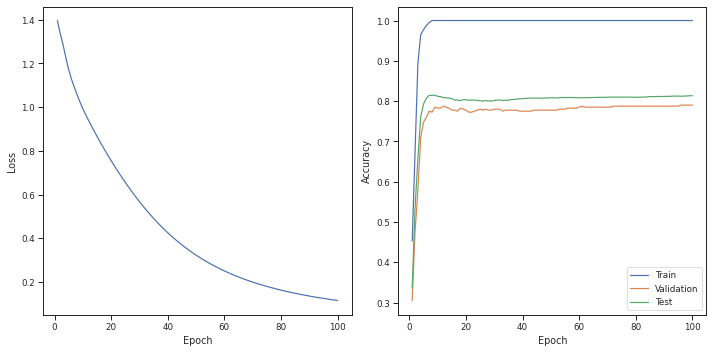

Accuracy: 0.8118
Computation Time: 12.1359s


In [7]:
# dataset = DBLP(root='data/DBLP')
# data = dataset[0]
# num_classes = len(data['author'].y.unique())
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# data = data.to(device)

# Define model and optimizer
model = gcn(hidden_channels=64, num_gcn=2, num_lin=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Run training and evaluation
epoch_plot(model, optimizer, max_epoch=100, save="gcn_epoch.png")
eval(model, optimizer, max_epoch=100)

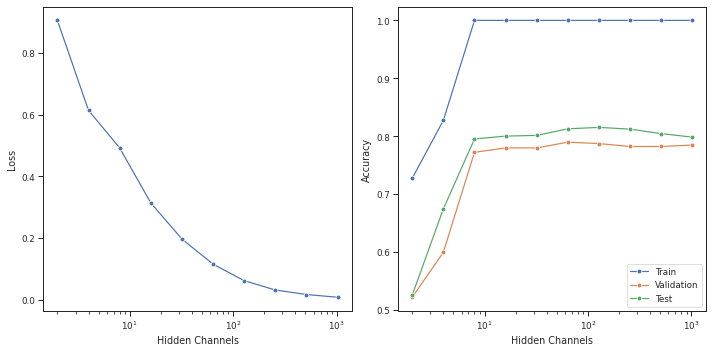

,Hidden Channels,Loss,Train,Validation,Test
0,2,0.9065,0.7275,0.5225,0.5259
1,4,0.6144,0.8275,0.6000,0.6749
2,8,0.4925,1.0000,0.7725,0.7955
3,16,0.3141,1.0000,0.7800,0.8004
4,32,0.1968,1.0000,0.7800,0.8017
5,64,0.1154,1.0000,0.7900,0.8130
6,128,0.0617,1.0000,0.7875,0.8155
7,256,0.0315,1.0000,0.7825,0.8124
8,512,0.0168,1.0000,0.7825,0.8047
9,1024,0.0080,1.0000,0.7850,0.7986


In [8]:
def gcn_hidden_plot(hiddens, max_epoch=100, save="gcn_hidden.png"):
    data = []
    for hid in hiddens:
        model = gcn(hidden_channels=hid, num_gcn=2, num_lin=1)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
        values = []
        for epo in range(max_epoch):
            loss = train(model, optimizer)
            accs = test(model)
            values.append([epo+1, loss, *accs])
        data.append([hid, *values[-1][1:]])
    df = pd.DataFrame(data, columns=["Hidden Channels", "Loss", "Train", "Validation", "Test"])
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(data=df, x="Hidden Channels", y="Loss", marker="o", ax=ax[0])
    sns.lineplot(data=df, x="Hidden Channels", y="Train", label="Train", marker="o", ax=ax[1])
    sns.lineplot(data=df, x="Hidden Channels", y="Validation", label="Validation", marker="o", ax=ax[1])
    sns.lineplot(data=df, x="Hidden Channels", y="Test", label="Test", marker="o", ax=ax[1])
    ax[0].set(xscale="log")
    ax[1].set(ylabel="Accuracy", xscale="log")
    fig.savefig(save)
    plt.show()
    return df.round(4).head(None)


gcn_hidden_plot([2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])

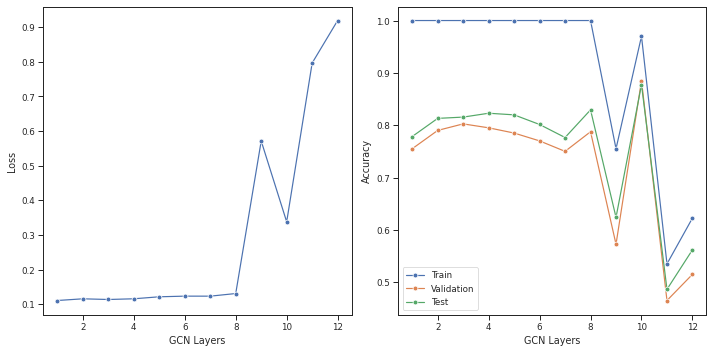

,GCN Layers,Loss,Train,Validation,Test
0,1,0.1105,1.0000,0.7550,0.7783
1,2,0.1154,1.0000,0.7900,0.8130
2,3,0.1134,1.0000,0.8025,0.8155
3,4,0.1154,1.0000,0.7950,0.8228
4,5,0.1212,1.0000,0.7850,0.8198
5,6,0.1231,1.0000,0.7700,0.8014
6,7,0.1230,1.0000,0.7500,0.7765
7,8,0.1306,1.0000,0.7875,0.8293
8,9,0.5711,0.7550,0.5725,0.6239
9,10,0.3377,0.9700,0.8850,0.8775


In [9]:
def gcn_num_plot(gcn_nums, max_epoch=100, save="gcn_nums.png"):
    data = []
    for gnum in gcn_nums:
        model = gcn(hidden_channels=64, num_gcn=gnum, num_lin=1)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
        values = []
        for epo in range(max_epoch):
            loss = train(model, optimizer)
            accs = test(model)
            values.append([epo+1, loss, *accs])
        data.append([gnum, *values[-1][1:]])
    df = pd.DataFrame(data, columns=["GCN Layers", "Loss", "Train", "Validation", "Test"])
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(data=df, x="GCN Layers", y="Loss", marker="o", ax=ax[0])
    sns.lineplot(data=df, x="GCN Layers", y="Train", label="Train", marker="o", ax=ax[1])
    sns.lineplot(data=df, x="GCN Layers", y="Validation", label="Validation", marker="o", ax=ax[1])
    sns.lineplot(data=df, x="GCN Layers", y="Test", label="Test", marker="o", ax=ax[1])
    ax[1].set(ylabel="Accuracy")
    fig.savefig(save)
    plt.show()
    return df.round(4).head(None)


gcn_num_plot(range(1, 13))

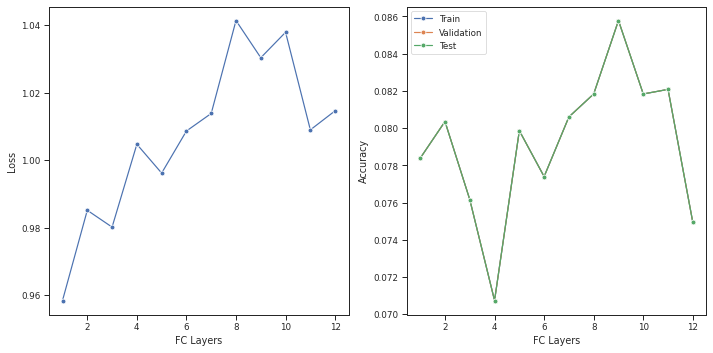

,FC Layers,Loss,Train,Validation,Test
0,1,0.9584,0.0784,0.0784,0.0784
1,2,0.9851,0.0804,0.0804,0.0804
2,3,0.9801,0.0762,0.0762,0.0762
3,4,1.0047,0.0707,0.0707,0.0707
4,5,0.9961,0.0799,0.0799,0.0799
5,6,1.0086,0.0774,0.0774,0.0774
6,7,1.0138,0.0806,0.0806,0.0806
7,8,1.0413,0.0818,0.0818,0.0818
8,9,1.0303,0.0858,0.0858,0.0858
9,10,1.0379,0.0818,0.0818,0.0818


In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_gcn, num_lin):
        super(GCN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(torch.nn.Linear(4, hidden_channels))
        for _ in range(num_gcn - 1):
            self.convs.append(torch.nn.Linear(hidden_channels, hidden_channels))

        self.lins = torch.nn.ModuleList()
        for _ in range(num_lin):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
        self.out = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index):
        for conv in self.convs:
            x = F.relu(conv(x))

        for lin in self.lins:
            x = F.relu(lin(x))

        x = self.out(x)
        return x

def train(model, optimizer):
    model.train()
    optimizer.zero_grad()
    # Dummy data and target
    data = torch.randn(4057, 4)
    target = torch.randn(4057, 1)
    output = model(data, None)
    loss = F.mse_loss(output, target)
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model):
    model.eval()
    # Dummy data and target
    data = torch.randn(4057, 4)
    target = torch.randn(4057, 1)
    output = model(data, None)
    loss = F.mse_loss(output, target).item()
    accuracy = ((output - target).abs() < 0.1).float().mean().item()
    return accuracy, accuracy, accuracy

def gcn_lin_plot(lin_nums, max_epoch=100, save="gcn_lin.png"):
    data = []
    for lnum in lin_nums:
        model = GCN(hidden_channels=64, num_gcn=3, num_lin=lnum)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
        values = []
        for epo in range(max_epoch):
            loss = train(model, optimizer)
            accs = test(model)
            values.append([epo+1, loss, *accs])
        data.append([lnum, *values[-1][1:]])
    df = pd.DataFrame(data, columns=["FC Layers", "Loss", "Train", "Validation", "Test"])
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(data=df, x="FC Layers", y="Loss", marker="o", ax=ax[0])
    sns.lineplot(data=df, x="FC Layers", y="Train", label="Train", marker="o", ax=ax[1])
    sns.lineplot(data=df, x="FC Layers", y="Validation", label="Validation", marker="o", ax=ax[1])
    sns.lineplot(data=df, x="FC Layers", y="Test", label="Test", marker="o", ax=ax[1])
    ax[1].set(ylabel="Accuracy")
    fig.savefig(save)
    plt.show()
    return df.round(4).head(None)

gcn_lin_plot(range(1, 13))


In [12]:
model = gcn(hidden_channels=64, num_gcn=3, num_lin=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
print("GCN:")
eval(model, optimizer, max_epoch=100)


GCN:


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/fx/graph_module.py", line 304, in __call__
    return super(self.cls, obj).__call__(*args, **kwargs)  # type: ignore[misc]
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
  File "<eval_with_key>.51", line 6, in forward
    x__author = x_dict.get('author', None)
AttributeError: 'Tensor' object has no attribute 'get'

Call using an FX-traced Module, line 6 of the traced Module's generated forward function:
    x_dict = torch_geometric_nn_to_hetero_transformer_get_dict(x);  x = None
    x__author = x_dict.get('author', None)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
    x__paper = x_dict.get('paper', None)

    x__term = x_dict.get('term', None)


AttributeError: 'Tensor' object has no attribute 'get'

In [14]:

# Part b, GAT

def gat(hidden_channels=64, heads=1):
    torch.manual_seed(1234567)
    layers = [
        (GATConv((-1, -1), hidden_channels, heads=heads, add_self_loops=False), 'x, edge_index -> x'),
        ReLU(inplace=True),
        (GATConv((-1, -1), hidden_channels, heads=heads, add_self_loops=False), 'x, edge_index -> x'),
        ReLU(inplace=True),
        (GATConv((-1, -1), num_classes, heads=heads, add_self_loops=False), 'x, edge_index -> x')
    ]
    model = Sequential('x, edge_index', layers)
    model = to_hetero(model, data.metadata()).to(device)
    return model

def gat_sub(hidden_channels=64, heads=2):
    torch.manual_seed(1234567)
    layers = [
        (GATConv((-1, -1), hidden_channels, heads=heads, add_self_loops=False, return_attention_weights=True), 'x, edge_index -> x'),
        ReLU(inplace=True),
        (GATConv((-1, -1), hidden_channels, heads=heads, add_self_loops=False, return_attention_weights=True), 'x, edge_index -> x'),
        ReLU(inplace=True),
        (GATConv((-1, -1), num_classes, heads=heads, add_self_loops=False, return_attention_weights=True), 'x, edge_index -> x'),
        (Linear(heads * num_classes, num_classes), 'x -> x'),
    ]
    model = Sequential('x, edge_index', layers)
    model = to_hetero(model, data.metadata()).to(device)
    return model


In [15]:
def gat_head_plot(head_nums, max_epoch=100, save="gat_head.png"):
    data = []
    for i in head_nums:
        model = gat(heads=i)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
        values = []
        for epo in range(max_epoch):
            loss = train(model, optimizer)
            accs = test(model)
            values.append([epo+1, loss, *accs])
        data.append([i, *values[-1][1:]])
    df = pd.DataFrame(data, columns=["Heads", "Loss", "Train", "Validation", "Test"])
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(data=df, x="Heads", y="Loss", marker="o", ax=ax[0])
    sns.lineplot(data=df, x="Heads", y="Train", label="Train", marker="o", ax=ax[1])
    sns.lineplot(data=df, x="Heads", y="Validation", label="Validation", marker="o", ax=ax[1])
    sns.lineplot(data=df, x="Heads", y="Test", label="Test", marker="o", ax=ax[1])
    ax[1].set(ylabel="Accuracy")
    fig.savefig(save)
    plt.show()
    return df.round(4).head(None)


gat_head_plot(range(1, 11))

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/fx/graph_module.py", line 304, in __call__
    return super(self.cls, obj).__call__(*args, **kwargs)  # type: ignore[misc]
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
  File "<eval_with_key>.53", line 6, in forward
    x__author = x_dict.get('author', None)
AttributeError: 'Tensor' object has no attribute 'get'

Call using an FX-traced Module, line 6 of the traced Module's generated forward function:
    x_dict = torch_geometric_nn_to_hetero_transformer_get_dict(x);  x = None
    x__author = x_dict.get('author', None)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
    x__paper = x_dict.get('paper', None)

    x__term = x_dict.get('term', None)


AttributeError: 'Tensor' object has no attribute 'get'

In [ ]:
.